In [1]:

import math # Mathematical functions
import numpy as np # Fundamental package for scientific computing with Python
import pandas as pd # Additional functions for analysing and manipulating data
from datetime import date # Date Functions
import matplotlib.pyplot as plt # Important package for visualization - we use this to plot the market data
import matplotlib.dates as mdates # Formatting dates
from sklearn.metrics import mean_absolute_error, mean_squared_error # Packages for measuring model performance / errors
import tensorflow as tf
from tensorflow.keras.models import Sequential # Deep learning library, used for neural networks
from tensorflow.keras.layers import LSTM, Dense, Dropout # Deep learning classes for recurrent and regular densely-connected layers
from tensorflow.keras.callbacks import EarlyStopping # EarlyStopping during model training
from sklearn.preprocessing import RobustScaler, MinMaxScaler # This Scaler removes the median and scales the data according to the quantile range to normalize the price data
#from keras.optimizers import Adam # For detailed configuration of the optimizer
import seaborn as sns # Visualization
plt.rcParams["grid.color"] = "k"  # Esto pone una cuadrícula con líneas de color negro
plt.rcParams["grid.alpha"] = 0.1  # Esto hace que las líneas de la cuadrícula sean muy transparentes
%matplotlib inline
from google.colab import files
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler


In [2]:
daily_variables = ['Open', 'Close', 'High', 'Low', 'Volume', 'MA1', 'MA2', 'Market Cap']
indicators = ['RSI', 'EMA14', 'EMA50', 'MACD', 'ADX', 'CMF', 'SO', 'LBOLLINGER', 'HBOLLINGER', 'FI']
daily_variables.extend(indicators)

dataframes = {}
lagged_dataframes = {}
stationary_dataframes = {}
lagged_stationary_dataframes = {}


In [3]:
brands = ['F', 'GM', 'TSLA', 'RACE', 'TM', 'HMC' ]

La función set_index establece la columna 'Date' como índice de un DataFrame, convierte los valores del índice a objetos de tipo datetime y devuelve el DataFrame modificado. Para usarla, llama a la función pasando el DataFrame como argumento.

In [4]:
def set_index(df):
   
   df = df.set_index('Date')
   df.index.name = 'Date'
   df.index = pd.to_datetime(df.index)
   return df


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
for brand in brands:
   df = pd.read_csv(f'/content/drive/MyDrive/TFG/Merged_Data/{brand}-merged.csv')
   dataframes[brand] = set_index(df)
   df = pd.read_csv(f'/content/drive/MyDrive/TFG/Lags/Non_Stationary/{brand}_lagged_non_stationary.csv')
   lagged_dataframes[brand] = set_index(df)
   df = pd.read_csv(f'/content/drive/MyDrive/TFG/Estacionaridad/{brand}_stationary.csv')
   stationary_dataframes[brand] = set_index(df)
   df = pd.read_csv(f'/content/drive/MyDrive/TFG/Lags/Stationary/{brand}_lagged_stationary.csv')
   lagged_stationary_dataframes[brand] = set_index(df)

El código calcula y muestra la varianza del último 20% de los datos en la columna 'Target' de cada DataFrame en el diccionario dataframes.

In [7]:
# Ahora, calcula y muestra la varianza para el último 20% de los datos en la columna 'Target' en cada dataframe
for brand, dataframe in dataframes.items():
   # Selecciona el último 20% de las filas
   last_20_percent = dataframe['Target'].tail(int(len(dataframe) * 0.2))

   # Calcula la varianza para el último 20% de las filas
   variance = last_20_percent.var()

   print(f'Para la marca {brand}, la varianza del último 20% de los datos es: {variance}')

Para la marca F, la varianza del último 20% de los datos es: 14.18423797671122
Para la marca GM, la varianza del último 20% de los datos es: 102.44868782965803
Para la marca TSLA, la varianza del último 20% de los datos es: 3940.5612015681045
Para la marca RACE, la varianza del último 20% de los datos es: 1073.1962046320832
Para la marca TM, la varianza del último 20% de los datos es: 421.23846998389894
Para la marca HMC, la varianza del último 20% de los datos es: 6.945305419018702



La función count_inf cuenta la cantidad de valores infinitos en un DataFrame. Para usarla, llama a la función count_inf pasando el DataFrame como argumento. Luego, se itera sobre una lista llamada brands, y para cada marca en esa lista, se crea una copia del DataFrame correspondiente, se aplica la función count_inf a cada columna del DataFrame, se filtran los valores mayores a 0 y se imprime el resultado. 

In [ ]:
import numpy as np
import pandas as pd

# suponiendo que df es el dataframe
def count_inf(df):
    return ((df == np.inf) | (df == -np.inf)).sum()

for brand in brands:

  df = stationary_dataframes[brand].copy()

  inf_count = df.apply(count_inf)
  inf_count = inf_count[inf_count > 0]

  print(brand, inf_count)



F Series([], dtype: int64)
GM Series([], dtype: int64)
TSLA Series([], dtype: int64)
RACE Series([], dtype: int64)
TM Series([], dtype: int64)
HMC Series([], dtype: int64)


# FEATURE SELECTION


LASSO

Este código realiza la selección de características utilizando Lasso y validación cruzada. Para cada marca en la lista brands, se ajusta un modelo Lasso con diferentes valores de alpha y se seleccionan las características más importantes. Finalmente, se muestra una gráfica del puntaje de validación cruzada en función de alpha para cada marca. 

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV,TimeSeriesSplit
# Define the model
alphas = np.logspace(-4, -1, 1000)

lassofeatures_nolags = {}
lassofeatures_lags = {}


for counter in range(2):
  if counter == 0:
    print('Stationary DataFrames:-------------------------------------------------------')
    plt.figure(figsize=(10, 6))

  else:
    print('\n \n \n')
    print('Stationary Lagged DataFrames:-------------------------------------------------------')
    plt.figure(figsize=(10, 6))

  for brand in brands:
    if counter == 0:
      dfs = stationary_dataframes[brand].copy()

    else:
      dfs =  lagged_stationary_dataframes[brand].copy()

    df_features = dfs.drop(['Target', 'Nominal_Close'], axis=1)
    df_target = dfs['Target']

    # Crea una instancia de la clase Lasso
    lasso = Lasso()

    # TimeSeriesSplit for cross-validation
    tscv = TimeSeriesSplit(n_splits=3)  # replace with your preferred number of splits

    # Scaling the features
    scaler = RobustScaler()
    df_features_scaled = pd.DataFrame(scaler.fit_transform(df_features), columns=df_features.columns)
    scaler_pred = RobustScaler()
    df_target_scaled = pd.Series(scaler_pred.fit_transform(df_target.values.reshape(-1, 1)).flatten())

    # Define the grid search
    grid = GridSearchCV(estimator=lasso, param_grid=dict(alpha=alphas), cv=tscv, n_jobs = -1, return_train_score=True)
    grid.fit(df_features_scaled, df_target_scaled)
    # Print the best alpha
    print('Best alpha: ', grid.best_estimator_.alpha)

    # Create a selector object that uses the Lasso model to identify features with non-zero coefficients
    sel_ = SelectFromModel(grid.best_estimator_)  # Uses the best model from the grid

    # Fit the selector object to the data
    sel_.fit(df_features_scaled, df_target_scaled)

    # Print the names of the most important features
    selected_feat = df_features.columns[(sel_.get_support())]
    print(brand)
    print('Lasso for', brand, 'has selected the following features:\n', selected_feat)
    if counter == 0:
      lassofeatures_nolags[brand] = selected_feat
    else:
      lassofeatures_lags[brand] = selected_feat

    # Plot the mean cross-validation score as a function of alpha
    plt.semilogx(alphas, -grid.cv_results_["mean_test_score"], label=brand)

  # Añade etiquetas y título
  plt.xlabel('Alpha')
  plt.ylabel('Mean cross-validation score')
  plt.title('Cross-validation score as a function of alpha')
  plt.legend()
  plt.grid()
  plt.show()

Stationary DataFrames:-------------------------------------------------------


KeyboardInterrupt: ignored

<Figure size 1000x600 with 0 Axes>

In [ ]:
selected_feat[120:190]

Index(['Revenue Growth (YoY)_lag5', 'Net Income Growth_lag4',
       'Net Income Growth_lag5', 'Shares Outstanding (Basic)_lag2',
       'Shares Outstanding (Basic)_lag3', 'Shares Outstanding (Basic)_lag5',
       'Effective Tax Rate_lag2', 'Effective Tax Rate_lag3',
       'Effective Tax Rate_lag4', 'PE Ratio_lag1', 'PE Ratio_lag2',
       'PE Ratio_lag4', 'PE Ratio_lag5', 'PB Ratio_lag3', 'PB Ratio_lag5',
       'Current Ratio_lag1', 'Current Ratio_lag4', 'Current Ratio_lag5'],
      dtype='object')

A continuación se muestran las variables seleccionadas por Lasso

In [ ]:

lassofeatures_nolags = {}
lassofeatures_lags = {}

lassofeatures_nolags['F'] = ['High', 'MA1', 'Cash & Equivalents', 'Cash & Cash Equivalents',
       'Other Current Assets', 'Other Long-Term Assets', 'Current Debt',
       'Total Current Liabilities', 'Other Current Liabilities',
       'Retained Earnings', 'Comprehensive Income', "Shareholders' Equity",
       'Net Cash Per Share', 'Working Capital', 'Other Operating Activities',
       'Operating Cash Flow', 'Other Investing Activities',
       'Investing Cash Flow', 'Debt Issued / Paid',
       'Other Financing Activities', 'Net Cash Flow', 'Free Cash Flow Growth',
       'Gross Profit', 'Selling, General & Admin', 'Operating Income',
       'Interest Expense / Income', 'Pretax Income',
       'Shares Outstanding (Basic)', 'Shares Outstanding (Diluted)',
       'EPS (Basic)', 'EPS (Diluted)', 'Gross Margin', 'Operating Margin',
       'Profit Margin', 'Effective Tax Rate', 'EBITDA Margin', 'PE Ratio',
       'PS Ratio', 'Current Ratio', 'Buyback Yield / Dilution',
       'Total Shareholder Return', 'MACD', 'CMF', 'LBOLLINGER', 'HBOLLINGER']
lassofeatures_nolags['GM'] = ['MA1', 'MA2', 'Cash & Equivalents', 'Cash Growth',
       'Other Current Assets', 'Other Long-Term Assets', 'Long-Term Debt',
       'Common Stock', 'Comprehensive Income', 'Other Operating Activities',
       'Operating Cash Flow', 'Operating Cash Flow Growth',
       'Other Investing Activities', 'Investing Cash Flow', 'Dividends Paid',
       'Debt Issued / Paid', 'Financing Cash Flow', 'Net Cash Flow',
       'Free Cash Flow Margin_x', 'Cost of Revenue', 'Gross Profit',
       'Other Expense / Income', 'Pretax Income', 'Net Income Growth',
       'Shares Outstanding (Basic)', 'Shares Change', 'Profit Margin',
       'Market Cap Growth', 'EMA50', 'MACD', 'CMF', 'LBOLLINGER']

lassofeatures_nolags['TSLA'] =['MA1', 'Cash Growth', 'Other Current Assets', 'Deferred Revenue',
       'Current Debt', 'Long-Term Debt', 'Debt Growth', 'Retained Earnings',
       'Net Cash / Debt', 'Share-Based Compensation',
       'Other Operating Activities', 'Operating Cash Flow Growth',
       'Other Investing Activities', 'Investing Cash Flow',
       'Debt Issued / Paid', 'Other Financing Activities',
       'Financing Cash Flow', 'Free Cash Flow Growth', 'Revenue',
       'Revenue Growth (YoY)', 'Research & Development',
       'Other Expense / Income', 'Pretax Income', 'Income Tax',
       'Shares Outstanding (Diluted)', 'EPS Growth', 'EBITDA', 'PE Ratio',
       'PS Ratio', 'MACD', 'CMF', 'FI']
lassofeatures_nolags['RACE'] = ['Open', 'Close', 'High', 'Low', 'Volume', 'MA1', 'MA2',
       'Cash & Equivalents', 'Short-Term Investments', 'Cash Growth',
       'Receivables', 'Inventory', 'Total Current Assets',
       'Long-Term Investments', 'Goodwill and Intangibles',
       'Other Long-Term Assets', 'Total Long-Term Assets', 'Accounts Payable',
       'Common Stock', 'Net Cash / Debt', 'Net Cash / Debt Growth',
       'Net Income_x', 'Depreciation & Amortization_x',
       'Other Operating Activities', 'Operating Cash Flow Growth',
       'Debt Issued / Paid', 'Other Financing Activities',
       'Financing Cash Flow', 'Free Cash Flow Growth', 'Revenue',
       'Revenue Growth (YoY)', 'Cost of Revenue', 'Gross Profit',
       'Selling, General & Admin', 'Operating Income',
       'Other Expense / Income', 'Income Tax', 'Net Income_y',
       'Net Income Growth', 'EPS (Basic)', 'EPS (Diluted)', 'EPS Growth',
       'Dividend Growth', 'Gross Margin', 'Operating Margin',
       'Effective Tax Rate', 'EBITDA', 'Depreciation & Amortization_y', 'EBIT',
       'EBIT Margin', 'Market Cap', 'Market Capitalization',
       'Market Cap Growth', 'Enterprise Value', 'PE Ratio', 'PS Ratio', 'RSI',
       'EMA14', 'EMA50', 'MACD', 'ADX', 'CMF', 'SO', 'LBOLLINGER',
       'HBOLLINGER', 'FI']

lassofeatures_nolags['TM'] = ['Cash Growth', 'Other Long-Term Assets', 'Common Stock',
       'Working Capital', 'Net Income_x', 'Other Operating Activities',
       'Operating Cash Flow', 'Operating Cash Flow Growth',
       'Change in Investments', 'Other Investing Activities',
       'Share Issuance / Repurchase', 'Debt Issued / Paid',
       'Other Financing Activities', 'Financing Cash Flow', 'Net Cash Flow',
       'Free Cash Flow', 'Cost of Revenue', 'Operating Income',
       'Interest Expense / Income', 'Pretax Income', 'Income Tax',
       'Net Income_y', 'EPS (Diluted)', 'EPS Growth', 'Dividend Growth',
       'Effective Tax Rate', 'Market Cap Growth', 'Enterprise Value', 'EMA14',
       'MACD', 'CMF', 'LBOLLINGER', 'FI']

lassofeatures_nolags['HMC'] = ['Cash Growth', 'Property, Plant & Equipment', 'Debt Growth',
       'Common Stock', 'Working Capital', 'Depreciation & Amortization_x',
       'Operating Cash Flow', 'Capital Expenditures', 'Change in Investments',
       'Other Investing Activities', 'Debt Issued / Paid',
       'Other Financing Activities', 'Financing Cash Flow', 'Net Cash Flow',
       'Free Cash Flow', 'Free Cash Flow Per Share_x',
       'Other Expense / Income', 'Net Income Growth', 'EPS Growth',
       'Free Cash Flow Per Share_y', 'Gross Margin', 'Operating Margin',
       'Profit Margin', 'Effective Tax Rate', 'EBITDA Margin',
       'Depreciation & Amortization_y', 'EBIT Margin', 'Market Cap Growth',
       'Enterprise Value', 'PE Ratio', 'Current Ratio', 'EMA50', 'MACD', 'CMF',
       'FI']

lassofeatures_lags['F'] =['Open', 'High', 'Low', 'Volume', 'MA1', 'MA2', 'Cash & Equivalents',
       'Short-Term Investments', 'Cash & Cash Equivalents',
       'Other Current Assets', 'Long-Term Investments', 'Current Debt',
       'Other Current Liabilities', 'Total Debt', 'Common Stock',
       'Retained Earnings', 'Comprehensive Income', "Shareholders' Equity",
       'Net Cash / Debt', 'Working Capital', 'Book Value Per Share',
       'Other Operating Activities', 'Operating Cash Flow',
       'Change in Investments', 'Other Investing Activities',
       'Investing Cash Flow', 'Debt Issued / Paid',
       'Other Financing Activities', 'Financing Cash Flow', 'Free Cash Flow',
       'Free Cash Flow Growth', 'Free Cash Flow Margin_x', 'Gross Profit',
       'Selling, General & Admin', 'Operating Expenses', 'Operating Income',
       'Interest Expense / Income', 'Pretax Income', 'Income Tax',
       'Net Income_y', 'Shares Outstanding (Basic)', 'EPS (Basic)',
       'EPS (Diluted)', 'Free Cash Flow Margin_y', 'EBIT', 'EBIT Margin',
       'Market Cap', 'PE Ratio', 'Debt / Equity Ratio', 'Current Ratio',
       'Buyback Yield / Dilution', 'EMA14', 'MACD', 'CMF', 'HBOLLINGER', 'FI',
       'Open_lag1', 'Open_lag2', 'Open_lag3', 'Open_lag4', 'Open_lag5',
       'Open_lag6', 'Open_lag8', 'Open_lag9', 'Open_lag10', 'Open_lag11',
       'Open_lag12', 'Open_lag13', 'Open_lag14', 'Open_lag15', 'Open_lag16',
       'Open_lag17', 'Close_lag2', 'Close_lag9', 'Close_lag10', 'Close_lag11',
       'Close_lag12', 'Close_lag13', 'Close_lag14', 'Close_lag15', 'Close_lag16', 'High_lag1', 'High_lag2', 'High_lag3', 'High_lag5',
       'High_lag7', 'High_lag8', 'High_lag9', 'High_lag10', 'High_lag11',
       'High_lag12', 'High_lag13', 'High_lag14', 'High_lag16', 'High_lag17',
       'High_lag18', 'High_lag19', 'High_lag20', 'Low_lag1', 'Low_lag3',
       'Low_lag4', 'Low_lag5', 'Low_lag6', 'Low_lag7', 'Low_lag8', 'Low_lag9',
       'Low_lag10', 'Low_lag14', 'Low_lag15', 'Low_lag16', 'Low_lag17',
       'Low_lag18', 'Low_lag19', 'Low_lag20', 'Volume_lag1', 'Volume_lag2',
       'Volume_lag3', 'Volume_lag4', 'Volume_lag5', 'Volume_lag6',
       'Volume_lag7', 'Volume_lag8', 'Volume_lag9', 'Volume_lag10',
       'Volume_lag11', 'Volume_lag12', 'Volume_lag13', 'Volume_lag14',
       'Volume_lag15', 'Volume_lag16', 'Volume_lag17', 'Volume_lag18',
       'Volume_lag19', 'Volume_lag20', 'MA1_lag1', 'MA1_lag5', 'MA1_lag7',
       'MA1_lag8', 'MA1_lag9', 'MA1_lag10', 'MA1_lag11', 'MA1_lag12',
       'MA1_lag13', 'MA1_lag15', 'MA1_lag16', 'MA1_lag17', 'MA1_lag19',
       'MA1_lag20', 'MA2_lag1', 'MA2_lag2', 'MA2_lag4', 'MA2_lag9',
       'MA2_lag13', 'MA2_lag19', 'MA2_lag20', 'Market Cap_lag1',
       'Market Cap_lag2', 'Market Cap_lag3', 'Market Cap_lag4',
       'Market Cap_lag5', 'Market Cap_lag7', 'Market Cap_lag8',
       'Market Cap_lag10', 'Market Cap_lag12', 'Market Cap_lag13',
       'Market Cap_lag14', 'Market Cap_lag15', 'Market Cap_lag16',
       'Market Cap_lag17', 'Market Cap_lag18','Market Cap_lag19', 'RSI_lag2', 'RSI_lag3', 'RSI_lag4', 'RSI_lag5',
       'RSI_lag6', 'RSI_lag7', 'RSI_lag8', 'RSI_lag11', 'RSI_lag12',
       'RSI_lag13', 'RSI_lag17', 'RSI_lag18', 'RSI_lag19', 'RSI_lag20',
       'EMA14_lag1', 'EMA14_lag2', 'EMA14_lag5', 'EMA14_lag6', 'EMA14_lag20',
       'EMA50_lag1', 'EMA50_lag10', 'EMA50_lag12', 'EMA50_lag13',
       'EMA50_lag14', 'EMA50_lag15', 'EMA50_lag16', 'EMA50_lag20', 'MACD_lag1',
       'MACD_lag2', 'MACD_lag3', 'MACD_lag4', 'MACD_lag5', 'MACD_lag6',
       'MACD_lag7', 'MACD_lag8', 'MACD_lag9', 'MACD_lag10', 'MACD_lag11',
       'MACD_lag12', 'MACD_lag13', 'MACD_lag14', 'MACD_lag15', 'MACD_lag16',
       'MACD_lag17', 'MACD_lag18', 'MACD_lag19', 'MACD_lag20', 'ADX_lag2',
       'ADX_lag3', 'ADX_lag4', 'ADX_lag7', 'ADX_lag10', 'ADX_lag11',
       'ADX_lag16', 'ADX_lag17', 'ADX_lag18', 'ADX_lag19', 'ADX_lag20',
       'CMF_lag1', 'CMF_lag2', 'CMF_lag3', 'CMF_lag4', 'CMF_lag5', 'CMF_lag6',
       'CMF_lag7', 'CMF_lag8', 'CMF_lag9', 'CMF_lag10', 'CMF_lag11',
       'CMF_lag12', 'CMF_lag13', 'CMF_lag14', 'CMF_lag15', 'CMF_lag16',
       'CMF_lag17', 'CMF_lag18', 'CMF_lag19', 'CMF_lag20', 'SO_lag4',
       'SO_lag7', 'SO_lag8', 'SO_lag11', 'SO_lag12', 'SO_lag18', 'SO_lag19',
       'SO_lag20', 'LBOLLINGER_lag4', 'LBOLLINGER_lag5', 'LBOLLINGER_lag6', 'LBOLLINGER_lag7', 'LBOLLINGER_lag8', 'LBOLLINGER_lag9',
       'LBOLLINGER_lag10', 'LBOLLINGER_lag12', 'LBOLLINGER_lag13',
       'LBOLLINGER_lag15', 'LBOLLINGER_lag17', 'LBOLLINGER_lag18',
       'LBOLLINGER_lag19', 'LBOLLINGER_lag20', 'HBOLLINGER_lag1',
       'HBOLLINGER_lag2', 'HBOLLINGER_lag3', 'HBOLLINGER_lag6',
       'HBOLLINGER_lag8', 'HBOLLINGER_lag9', 'HBOLLINGER_lag13',
       'HBOLLINGER_lag14', 'HBOLLINGER_lag16', 'HBOLLINGER_lag18',
       'HBOLLINGER_lag19', 'FI_lag1', 'FI_lag2', 'FI_lag3', 'FI_lag4',
       'FI_lag5', 'FI_lag6', 'FI_lag7', 'FI_lag8', 'FI_lag9', 'FI_lag10',
       'FI_lag11', 'FI_lag12', 'FI_lag13', 'FI_lag14', 'FI_lag15', 'FI_lag16',
       'FI_lag17', 'FI_lag18', 'FI_lag19', 'Target_lag7', 'Target_lag8',
       'Target_lag9', 'Target_lag10', 'Target_lag11', 'Target_lag12',
       'Target_lag13', 'Target_lag14', 'Target_lag15',
       'Cash & Cash Equivalents_lag3', 'Other Current Assets_lag1',
       'Other Current Assets_lag2', 'Other Current Assets_lag3',
       'Other Current Assets_lag4', 'Other Current Assets_lag5',
       'Current Debt_lag1', 'Current Debt_lag2', 'Current Debt_lag3',
       'Total Current Liabilities_lag1', 'Total Current Liabilities_lag2',
       'Total Current Liabilities_lag5', 'Other Current Liabilities_lag1',
       'Other Current Liabilities_lag3', 'Other Current Liabilities_lag5',
       'Common Stock_lag2', 'Common Stock_lag4', 'Retained Earnings_lag1',
       'Retained Earnings_lag2', 'Retained Earnings_lag3',
       'Retained Earnings_lag4', 'Retained Earnings_lag5',
       'Comprehensive Income_lag1', 'Comprehensive Income_lag2',
       'Comprehensive Income_lag3', 'Net Cash / Debt_lag3',
       'Net Cash / Debt_lag5', 'Working Capital_lag1', 'Working Capital_lag2',
       'Working Capital_lag3', 'Working Capital_lag4', 'Working Capital_lag5',
       'Other Operating Activities_lag1', 'Other Investing Activities_lag2',
       'Other Investing Activities_lag3', 'Debt Issued / Paid_lag1',
       'Debt Issued / Paid_lag2', 'Debt Issued / Paid_lag3',
       'Debt Issued / Paid_lag5', 'Other Financing Activities_lag1', 'Other Financing Activities_lag3', 'Other Financing Activities_lag4',
       'Financing Cash Flow_lag2', 'Financing Cash Flow_lag3',
       'Financing Cash Flow_lag4', 'Free Cash Flow_lag2',
       'Free Cash Flow Growth_lag1', 'Free Cash Flow Growth_lag2',
       'Free Cash Flow Growth_lag3', 'Free Cash Flow Growth_lag4',
       'Free Cash Flow Growth_lag5', 'Revenue Growth (YoY)_lag1',
       'Selling, General & Admin_lag1', 'Selling, General & Admin_lag2',
       'Selling, General & Admin_lag3', 'Operating Income_lag1',
       'Operating Income_lag3', 'Pretax Income_lag1', 'Pretax Income_lag2',
       'Pretax Income_lag3', 'Pretax Income_lag4', 'Pretax Income_lag5',
       'Income Tax_lag3', 'Income Tax_lag4', 'Income Tax_lag5',
       'Net Income Growth_lag4', 'Net Income Growth_lag5',
       'Shares Outstanding (Basic)_lag1', 'Shares Outstanding (Basic)_lag2',
       'Shares Outstanding (Basic)_lag3', 'Shares Outstanding (Basic)_lag4',
       'Shares Outstanding (Basic)_lag5', 'EPS (Basic)_lag2',
       'Gross Margin_lag5', 'Operating Margin_lag3', 'Effective Tax Rate_lag3',
       'PE Ratio_lag1', 'PE Ratio_lag2', 'PE Ratio_lag5', 'Current Ratio_lag4',
       'Buyback Yield / Dilution_lag1', 'Buyback Yield / Dilution_lag2',
       'Buyback Yield / Dilution_lag3']
lassofeatures_lags['GM'] = ['MA2', 'Net Cash / Debt', 'Other Operating Activities',
       'Operating Cash Flow', 'Operating Cash Flow Growth',
       'Change in Investments', 'Other Expense / Income', 'Pretax Income',
       'Effective Tax Rate', 'EMA14', 'EMA50', 'MACD', 'CMF', 'LBOLLINGER',
       'High_lag20', 'MA1_lag3', 'MA1_lag6', 'MA1_lag7', 'MA1_lag8',
       'MA1_lag9', 'MA1_lag11', 'MA1_lag12', 'MA1_lag14', 'MA2_lag1',
       'MA2_lag2', 'EMA14_lag19', 'MACD_lag1', 'MACD_lag2', 'MACD_lag3',
       'MACD_lag4', 'MACD_lag5', 'MACD_lag7', 'MACD_lag8', 'MACD_lag9',
       'MACD_lag11', 'MACD_lag12', 'MACD_lag13', 'MACD_lag14', 'MACD_lag15',
       'MACD_lag16', 'MACD_lag17', 'MACD_lag18', 'ADX_lag7', 'ADX_lag8',
       'CMF_lag2', 'CMF_lag3', 'CMF_lag4', 'CMF_lag5', 'CMF_lag6', 'CMF_lag7',
       'CMF_lag10', 'CMF_lag11', 'CMF_lag12', 'CMF_lag17', 'CMF_lag19',
       'CMF_lag20', 'LBOLLINGER_lag2', 'LBOLLINGER_lag20', 'HBOLLINGER_lag18',
       'FI_lag1', 'FI_lag2', 'FI_lag5', 'FI_lag6', 'FI_lag7', 'FI_lag8',
       'FI_lag9', 'FI_lag10', 'FI_lag11', 'FI_lag12', 'FI_lag13', 'FI_lag14',
       'FI_lag15', 'FI_lag16', 'FI_lag17', 'FI_lag18', 'FI_lag19', 'FI_lag20',
       'Other Long-Term Assets_lag2', 'Other Long-Term Assets_lag3',
       'Other Long-Term Assets_lag4', 'Other Long-Term Assets_lag5',
       'Other Operating Activities_lag1', 'Other Operating Activities_lag3',
       'Operating Cash Flow_lag1', 'Operating Cash Flow_lag2',
       'Operating Cash Flow_lag3', 'Operating Cash Flow Growth_lag1',
       'Other Investing Activities_lag4', 'Financing Cash Flow_lag4',
       'Financing Cash Flow_lag5', 'Net Cash Flow_lag5', 'Free Cash Flow_lag1',
       'Free Cash Flow Margin_x_lag1', 'Other Expense / Income_lag1',
       'Other Expense / Income_lag2', 'Pretax Income_lag1',
       'Pretax Income_lag2', 'Pretax Income_lag4', 'Net Income Growth_lag2',
       'Net Income Growth_lag4','Net Income Growth_lag5', 'Free Cash Flow Margin_y_lag1']
lassofeatures_lags['TSLA'] = ['MA1', 'MA2', 'Cash Growth', 'Current Debt', 'Debt Growth',
       'Other Investing Activities', 'Investing Cash Flow',
       'Debt Issued / Paid', 'Financing Cash Flow', 'Revenue Growth (YoY)',
       'MACD', 'CMF', 'FI', 'MA1_lag1', 'MA1_lag2', 'MA1_lag3', 'MA1_lag4',
       'MA1_lag5', 'MA1_lag6', 'MA2_lag1', 'MA2_lag2', 'MACD_lag1',
       'MACD_lag4', 'MACD_lag6', 'MACD_lag7', 'MACD_lag8', 'MACD_lag10',
       'MACD_lag11', 'MACD_lag12', 'MACD_lag13', 'MACD_lag14', 'MACD_lag15',
       'MACD_lag17', 'MACD_lag18', 'MACD_lag19', 'MACD_lag20', 'CMF_lag4',
       'CMF_lag5', 'CMF_lag6', 'CMF_lag8', 'CMF_lag10', 'CMF_lag11',
       'CMF_lag14', 'CMF_lag15', 'CMF_lag17', 'CMF_lag18', 'CMF_lag19',
       'CMF_lag20', 'LBOLLINGER_lag6', 'LBOLLINGER_lag7', 'LBOLLINGER_lag8',
       'LBOLLINGER_lag9', 'LBOLLINGER_lag10', 'LBOLLINGER_lag11',
       'LBOLLINGER_lag12', 'LBOLLINGER_lag20', 'FI_lag1', 'FI_lag2', 'FI_lag3',
       'FI_lag4', 'FI_lag6', 'FI_lag8', 'FI_lag9', 'FI_lag10', 'FI_lag11',
       'FI_lag12', 'FI_lag13', 'FI_lag14', 'FI_lag15', 'FI_lag16', 'FI_lag18',
       'FI_lag19', 'FI_lag20', 'Cash Growth_lag1', 'Cash Growth_lag2',
       'Cash Growth_lag3', 'Cash Growth_lag4', 'Cash Growth_lag5',
       'Deferred Revenue_lag1', 'Current Debt_lag1', 'Current Debt_lag2',
       'Current Debt_lag3', 'Current Debt_lag4', 'Debt Growth_lag1',
       'Debt Growth_lag2', 'Debt Growth_lag3', 'Debt Growth_lag4',
       'Debt Growth_lag5', 'Operating Cash Flow Growth_lag1',
       'Operating Cash Flow Growth_lag4', 'Other Investing Activities_lag1',
       'Other Investing Activities_lag2', 'Other Investing Activities_lag3',
       'Other Investing Activities_lag4', 'Other Investing Activities_lag5',
       'Investing Cash Flow_lag1', 'Investing Cash Flow_lag2',
       'Investing Cash Flow_lag5', 'Debt Issued / Paid_lag2',
       'Debt Issued / Paid_lag3', 'Debt Issued / Paid_lag4', 'Debt Issued / Paid_lag5',
       'Other Financing Activities_lag3', 'Other Financing Activities_lag4',
       'Other Financing Activities_lag5', 'Revenue Growth (YoY)_lag1',
       'Other Expense / Income_lag1', 'Other Expense / Income_lag2',
       'Income Tax_lag2', 'Income Tax_lag3']

lassofeatures_lags['RACE'] = ['Open', 'High', 'MA1', 'MA2', 'Long-Term Investments',
       'Other Long-Term Assets', 'Net Income_x',
       'Depreciation & Amortization_x', 'Other Operating Activities',
       'Operating Cash Flow Growth', 'Financing Cash Flow',
       'Free Cash Flow Growth', 'Revenue Growth (YoY)',
       'Selling, General & Admin', 'Operating Income', 'Income Tax',
       'Net Income_y', 'Net Income Growth', 'EPS (Basic)', 'EPS Growth',
       'Dividend Growth', 'Gross Margin', 'Effective Tax Rate', 'EBIT',
       'EBIT Margin', 'Market Cap', 'RSI', 'EMA14', 'EMA50', 'MACD', 'ADX',
       'CMF', 'SO', 'LBOLLINGER', 'FI', 'Open_lag1', 'Open_lag2', 'Open_lag3',
       'Open_lag4', 'Open_lag5', 'Open_lag6', 'Open_lag7', 'Open_lag8',
       'Open_lag9', 'Open_lag11', 'Open_lag12', 'Open_lag15', 'Open_lag16',
       'Open_lag17', 'Open_lag18', 'Open_lag19', 'Open_lag20', 'Close_lag4',
       'Close_lag5', 'Close_lag7', 'Close_lag8', 'Close_lag9', 'Close_lag12',
       'Close_lag13', 'Close_lag14', 'Close_lag15', 'Close_lag17',
       'Close_lag18', 'Close_lag19', 'Close_lag20', 'High_lag1', 'High_lag2',
       'High_lag4', 'High_lag5', 'High_lag7', 'High_lag8', 'High_lag9',
       'High_lag10', 'High_lag11', 'High_lag12', 'High_lag13', 'High_lag14',
       'High_lag15', 'High_lag16', 'High_lag17', 'High_lag18', 'High_lag19',
       'High_lag20', 'Low_lag1', 'Low_lag4', 'Low_lag5', 'Low_lag6',
       'Low_lag7', 'Low_lag9', 'Low_lag10', 'Low_lag11', 'Low_lag13',
       'Low_lag14', 'Low_lag15', 'Low_lag16', 'Low_lag18', 'Low_lag20',
       'Volume_lag1', 'Volume_lag2', 'Volume_lag3','Volume_lag4', 'Volume_lag5', 'Volume_lag6', 'Volume_lag7',
       'Volume_lag8', 'Volume_lag9', 'Volume_lag10', 'Volume_lag11',
       'Volume_lag12', 'Volume_lag13', 'Volume_lag14', 'Volume_lag16',
       'Volume_lag17', 'Volume_lag18', 'Volume_lag19', 'Volume_lag20',
       'MA1_lag1', 'MA1_lag2', 'MA1_lag4', 'MA1_lag6', 'MA1_lag7', 'MA1_lag8',
       'MA1_lag9', 'MA1_lag11', 'MA1_lag12', 'MA1_lag13', 'MA1_lag14',
       'MA1_lag15', 'MA1_lag16', 'MA1_lag17', 'MA1_lag18', 'MA1_lag19',
       'MA1_lag20', 'MA2_lag1', 'MA2_lag2', 'MA2_lag3', 'MA2_lag5', 'MA2_lag6',
       'MA2_lag9', 'MA2_lag11', 'MA2_lag12', 'MA2_lag13', 'MA2_lag14',
       'MA2_lag15', 'MA2_lag16', 'MA2_lag17', 'MA2_lag18', 'MA2_lag19',
       'MA2_lag20', 'Market Cap_lag2', 'Market Cap_lag3', 'Market Cap_lag4',
       'Market Cap_lag5', 'Market Cap_lag6', 'Market Cap_lag7',
       'Market Cap_lag8', 'Market Cap_lag9', 'Market Cap_lag10',
       'Market Cap_lag11', 'Market Cap_lag12', 'Market Cap_lag13',
       'Market Cap_lag14', 'Market Cap_lag15', 'Market Cap_lag18',
       'Market Cap_lag19', 'Market Cap_lag20', 'RSI_lag2', 'RSI_lag3',
       'RSI_lag6', 'RSI_lag7', 'RSI_lag11', 'RSI_lag12', 'RSI_lag13',
       'RSI_lag14', 'RSI_lag15', 'RSI_lag16', 'RSI_lag17', 'RSI_lag18',
       'RSI_lag19', 'RSI_lag20', 'EMA14_lag1', 'EMA14_lag2', 'EMA14_lag4',
       'EMA14_lag7', 'EMA14_lag10', 'EMA14_lag20', 'EMA50_lag11',
       'EMA50_lag13', 'EMA50_lag14', 'EMA50_lag15', 'EMA50_lag17',
       'EMA50_lag18', 'EMA50_lag19', 'MACD_lag1', 'MACD_lag2', 'MACD_lag3',
       'MACD_lag4', 'MACD_lag5', 'MACD_lag6', 'MACD_lag7','MACD_lag8', 'MACD_lag9', 'MACD_lag10', 'MACD_lag11', 'MACD_lag12',
       'MACD_lag13', 'MACD_lag14', 'MACD_lag15', 'MACD_lag16', 'MACD_lag17',
       'MACD_lag18', 'MACD_lag19', 'MACD_lag20', 'ADX_lag1', 'ADX_lag3',
       'ADX_lag4', 'ADX_lag5', 'ADX_lag6', 'ADX_lag7', 'ADX_lag8', 'ADX_lag10',
       'ADX_lag11', 'ADX_lag13', 'ADX_lag14', 'ADX_lag15', 'ADX_lag16',
       'ADX_lag17', 'ADX_lag18', 'ADX_lag20', 'CMF_lag1', 'CMF_lag2',
       'CMF_lag3', 'CMF_lag4', 'CMF_lag5', 'CMF_lag6', 'CMF_lag7', 'CMF_lag8',
       'CMF_lag9', 'CMF_lag10', 'CMF_lag11', 'CMF_lag12', 'CMF_lag13',
       'CMF_lag14', 'CMF_lag15', 'CMF_lag16', 'CMF_lag17', 'CMF_lag18',
       'CMF_lag19', 'CMF_lag20', 'SO_lag4', 'SO_lag6', 'SO_lag7', 'SO_lag8',
       'SO_lag9', 'SO_lag10', 'SO_lag11', 'SO_lag12', 'SO_lag13', 'SO_lag14',
       'SO_lag15', 'SO_lag16', 'SO_lag17', 'SO_lag18', 'SO_lag19', 'SO_lag20',
       'LBOLLINGER_lag1', 'LBOLLINGER_lag2', 'LBOLLINGER_lag3',
       'LBOLLINGER_lag4', 'LBOLLINGER_lag5', 'LBOLLINGER_lag6',
       'LBOLLINGER_lag7', 'LBOLLINGER_lag8', 'LBOLLINGER_lag9',
       'LBOLLINGER_lag10', 'LBOLLINGER_lag11', 'LBOLLINGER_lag12',
       'LBOLLINGER_lag13', 'LBOLLINGER_lag17', 'LBOLLINGER_lag18',
       'LBOLLINGER_lag19', 'LBOLLINGER_lag20', 'HBOLLINGER_lag2',
       'HBOLLINGER_lag5', 'HBOLLINGER_lag7', 'HBOLLINGER_lag9',
       'HBOLLINGER_lag11', 'HBOLLINGER_lag12', 'HBOLLINGER_lag13',
       'HBOLLINGER_lag14', 'HBOLLINGER_lag15', 'HBOLLINGER_lag16',
       'HBOLLINGER_lag18', 'HBOLLINGER_lag19', 'HBOLLINGER_lag20', 'FI_lag1',
       'FI_lag2', 'FI_lag3', 'FI_lag4', 'FI_lag5', 'FI_lag6', 'FI_lag7', 'FI_lag8', 'FI_lag9', 'FI_lag10', 'FI_lag11',
       'FI_lag12', 'FI_lag13', 'FI_lag14', 'FI_lag15', 'FI_lag16', 'FI_lag17',
       'FI_lag18', 'FI_lag19', 'FI_lag20', 'Target_lag7', 'Target_lag8',
       'Target_lag9', 'Target_lag10', 'Target_lag11', 'Target_lag12',
       'Target_lag13', 'Target_lag14', 'Target_lag16', 'Target_lag17',
       'Net Income_x_lag1', 'Net Income_x_lag2', 'Net Income_x_lag3',
       'Net Income_x_lag4', 'Net Income_x_lag5',
       'Other Operating Activities_lag1', 'Other Operating Activities_lag2',
       'Other Operating Activities_lag3', 'Other Operating Activities_lag4',
       'Other Operating Activities_lag5', 'Operating Cash Flow Growth_lag1',
       'Operating Cash Flow Growth_lag2', 'Operating Cash Flow Growth_lag3',
       'Operating Cash Flow Growth_lag4', 'Operating Cash Flow Growth_lag5']
lassofeatures_lags['TM'] = ['Net Income_x', 'Change in Investments', 'Share Issuance / Repurchase',
       'Debt Issued / Paid', 'Other Financing Activities',
       'Financing Cash Flow', 'Net Cash Flow', 'Free Cash Flow Margin_x',
       'Net Income_y', 'EPS (Basic)', 'EPS (Diluted)', 'Dividend Growth',
       'Free Cash Flow Margin_y', 'Market Cap', 'Market Cap Growth', 'EMA14',
       'MACD', 'LBOLLINGER', 'FI', 'MA1_lag9', 'MA1_lag10', 'MA2_lag4',
       'MA2_lag17', 'MA2_lag18', 'MA2_lag19', 'MA2_lag20', 'Market Cap_lag6',
       'EMA14_lag2', 'EMA14_lag3', 'EMA50_lag5', 'EMA50_lag10', 'MACD_lag1',
       'MACD_lag2', 'MACD_lag3', 'MACD_lag4', 'MACD_lag5', 'MACD_lag6',
       'MACD_lag7', 'MACD_lag8', 'MACD_lag9', 'MACD_lag10', 'MACD_lag11',
       'MACD_lag12', 'MACD_lag13', 'MACD_lag14', 'MACD_lag15', 'MACD_lag16',
       'MACD_lag17', 'MACD_lag18', 'MACD_lag20', 'CMF_lag2', 'CMF_lag3',
       'CMF_lag4', 'CMF_lag5', 'CMF_lag6', 'CMF_lag8', 'CMF_lag10',
       'CMF_lag11', 'CMF_lag12', 'CMF_lag13', 'CMF_lag14', 'CMF_lag15',
       'CMF_lag18', 'CMF_lag20', 'LBOLLINGER_lag17', 'LBOLLINGER_lag19',
       'LBOLLINGER_lag20', 'HBOLLINGER_lag9', 'HBOLLINGER_lag10',
       'HBOLLINGER_lag11', 'HBOLLINGER_lag16', 'FI_lag1', 'FI_lag2', 'FI_lag3',
       'FI_lag4', 'FI_lag5', 'FI_lag6', 'FI_lag8', 'FI_lag9', 'FI_lag10',
       'FI_lag11', 'FI_lag12', 'FI_lag13', 'FI_lag14', 'FI_lag15', 'FI_lag16',
       'FI_lag17', 'FI_lag18', 'FI_lag19', 'Cash Growth_lag5',
       'Other Long-Term Assets_lag4', 'Common Stock_lag2', 'Common Stock_lag3',
       'Working Capital_lag1', 'Net Income_x_lag2', 'Net Income_x_lag3',
       'Net Income_x_lag4', 'Net Income_x_lag5','Operating Cash Flow Growth_lag5', 'Change in Investments_lag1',
       'Change in Investments_lag5', 'Other Investing Activities_lag3',
       'Other Investing Activities_lag4', 'Other Investing Activities_lag5',
       'Share Issuance / Repurchase_lag1', 'Share Issuance / Repurchase_lag2',
       'Share Issuance / Repurchase_lag3', 'Share Issuance / Repurchase_lag4',
       'Share Issuance / Repurchase_lag5', 'Other Financing Activities_lag1',
       'Other Financing Activities_lag2', 'Other Financing Activities_lag3',
       'Other Financing Activities_lag4', 'Other Financing Activities_lag5',
       'Net Cash Flow_lag2', 'Net Cash Flow_lag3', 'Net Cash Flow_lag5',
       'Income Tax_lag3', 'Income Tax_lag5', 'Net Income_y_lag1',
       'Net Income_y_lag2', 'Net Income_y_lag3', 'Net Income_y_lag4',
       'Net Income_y_lag5', 'EPS (Basic)_lag1', 'EPS (Basic)_lag3',
       'EPS (Basic)_lag4', 'EPS (Basic)_lag5', 'EPS (Diluted)_lag1',
       'EPS (Diluted)_lag4', 'EPS (Diluted)_lag5', 'Dividend Growth_lag1',
       'Effective Tax Rate_lag4','Operating Cash Flow Growth_lag1', 'Operating Cash Flow Growth_lag2']

lassofeatures_lags['HMC'] =['Cash Growth', 'Other Long-Term Assets', 'Debt Growth', 'Common Stock',
       'Depreciation & Amortization_x', 'Change in Investments',
       'Other Investing Activities', 'Other Financing Activities',
       'Other Expense / Income', 'Net Income Growth', 'EPS (Basic)',
       'EPS Growth', 'Operating Margin', 'Effective Tax Rate',
       'Depreciation & Amortization_y', 'Market Cap Growth', 'EMA14', 'EMA50',
       'MACD', 'CMF', 'FI', 'MA1_lag2', 'MA1_lag4', 'MA2_lag4', 'MA2_lag5',
       'MA2_lag6', 'MA2_lag7', 'MACD_lag1', 'MACD_lag2', 'MACD_lag3',
       'MACD_lag4', 'MACD_lag5', 'MACD_lag6', 'MACD_lag7', 'MACD_lag10',
       'MACD_lag11', 'MACD_lag12', 'MACD_lag13', 'MACD_lag14', 'MACD_lag15',
       'MACD_lag16', 'MACD_lag17', 'MACD_lag20', 'CMF_lag2', 'CMF_lag3',
       'CMF_lag4', 'CMF_lag5', 'CMF_lag6', 'CMF_lag7', 'CMF_lag8', 'CMF_lag9',
       'CMF_lag10', 'CMF_lag11', 'CMF_lag14', 'CMF_lag15', 'CMF_lag16',
       'CMF_lag17', 'CMF_lag18', 'CMF_lag19', 'CMF_lag20', 'LBOLLINGER_lag20',
       'HBOLLINGER_lag14', 'HBOLLINGER_lag15', 'FI_lag1', 'FI_lag3', 'FI_lag4',
       'FI_lag5', 'FI_lag6', 'FI_lag7', 'FI_lag8', 'FI_lag10', 'FI_lag11',
       'FI_lag13', 'FI_lag14', 'FI_lag15', 'FI_lag16', 'FI_lag17', 'FI_lag18',
       'FI_lag19', 'FI_lag20', 'Debt Growth_lag1', 'Debt Growth_lag2',
       'Debt Growth_lag3', 'Debt Growth_lag4', 'Debt Growth_lag5',
       'Common Stock_lag1', 'Common Stock_lag2', 'Common Stock_lag3',
       'Common Stock_lag4', 'Common Stock_lag5', 'Working Capital_lag4',
       'Depreciation & Amortization_x_lag1',
       'Depreciation & Amortization_x_lag3',
       'Depreciation & Amortization_x_lag5', 'Operating Cash Flow_lag1',
       'Operating Cash Flow_lag3', 'Operating Cash Flow_lag4',
       'Other Investing Activities_lag1', 'Other Investing Activities_lag2',
       'Other Investing Activities_lag3', 'Other Investing Activities_lag4', 'Other Investing Activities_lag5',
       'Other Financing Activities_lag1', 'Other Financing Activities_lag3',
       'Other Financing Activities_lag4', 'Other Financing Activities_lag5',
       'Financing Cash Flow_lag1', 'Other Expense / Income_lag1',
       'Other Expense / Income_lag2', 'Other Expense / Income_lag4',
       'Other Expense / Income_lag5', 'Income Tax_lag2', 'Income Tax_lag5',
       'Net Income Growth_lag1', 'Net Income Growth_lag2',
       'Net Income Growth_lag3', 'Net Income Growth_lag4',
       'Net Income Growth_lag5', 'EPS (Diluted)_lag3', 'EPS Growth_lag2',
       'EPS Growth_lag4', 'EPS Growth_lag5', 'Profit Margin_lag2',
       'Profit Margin_lag3', 'Effective Tax Rate_lag1',
       'Effective Tax Rate_lag4', 'Depreciation & Amortization_y_lag3',
       'Depreciation & Amortization_y_lag5', 'EBIT_lag5', 'EBIT Margin_lag1',
       'EBIT Margin_lag2', 'Market Cap Growth_lag1', 'Market Cap Growth_lag3',
       'PE Ratio_lag5']





PCA


Este código utiliza PCA para reducción de dimensionalidad y visualización de la varianza acumulada explicada por los componentes principales. Se itera sobre cada marca en brands, se ajusta el modelo PCA y se muestra la varianza acumulada y las 5 variables más importantes para las primeras 5 componentes principales. Finalmente, se muestra un gráfico de la varianza acumulada en función del número de componentes principales. Asegúrate de tener las variables brands y stationary_dataframes correctamente definidas.

Brand: F
Component 1: 0.999999999829621
  Net Income Growth: -0.9999999999999775
  Other Current Liabilities: -1.0120009444799331e-07
  Other Current Assets: 9.820325093763373e-08
  Income Tax: -7.360292289318229e-08
  Retained Earnings: 5.43614075848705e-08
Component 2: 0.9999999999109624
  Other Current Assets: -0.9996667809541617
  Other Current Liabilities: 0.020918589036069437
  Operating Cash Flow: 0.0055368354838662365
  Retained Earnings: 0.005169638202356819
  Operating Expenses: -0.003982956142824897
Component 3: 0.999999999968142
  Other Current Liabilities: 0.9977356434210618
  Selling, General & Admin: 0.038796778933907934
  Other Investing Activities: -0.02443332132258521
  Total Current Liabilities: 0.021675889187772655
  Other Current Assets: 0.02089941297209474
Component 4: 0.9999999999808845
  Operating Cash Flow: -0.9985529135350657
  Other Investing Activities: -0.02745914496010609
  Retained Earnings: 0.017876321832041905
  Comprehensive Income: -0.0177674007918905

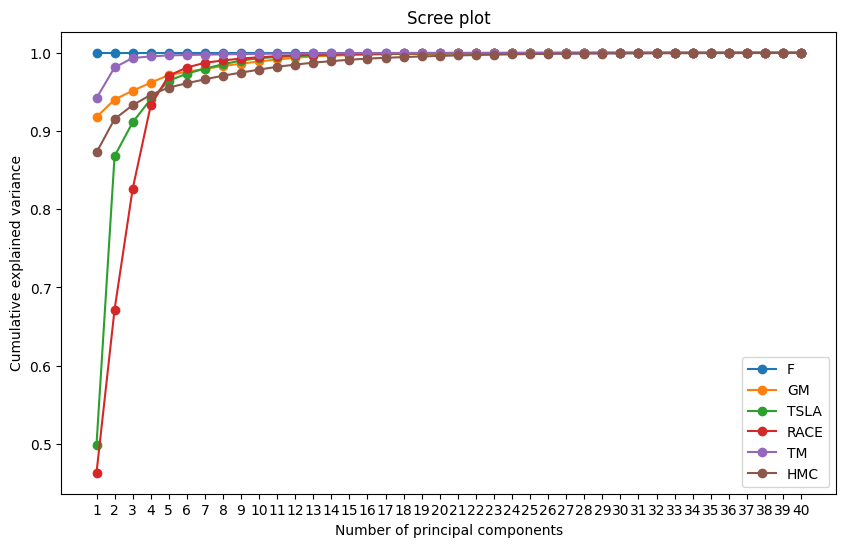

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

plt.figure(figsize=(10, 6))

# Define el mapa de colores
color_map = plt.get_cmap('tab10')

# Itera a través de cada marca
for i, brand in enumerate(brands):
    # Extrae el DataFrame correspondiente a la marca actual
    dfs = stationary_dataframes[brand].copy()

    # Separa las características y la variable objetivo
    df_features = dfs.drop(['Target', 'Nominal_Close'], axis=1)

    # Define el modelo PCA
    pca = PCA()

    # Escala las características
    scaler = RobustScaler()
    df_features_scaled = pd.DataFrame(scaler.fit_transform(df_features), columns=df_features.columns)

    # Ajusta el modelo PCA
    pca.fit(df_features_scaled)

    # Calcula la varianza acumulada
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

    # Dibuja la línea de la varianza acumulada para la marca actual
    plt.plot(range(1, len(cumulative_variance[:40]) + 1), cumulative_variance[:40], '-o', label=brand, color=color_map(i))

    # Imprime las 5 variables más importantes para cada una de las 5 primeras componentes
    print(f'Brand: {brand}')
    for j in range(5):
        # Recupera los coeficientes de la componente principal
        component = pca.components_[j]

        # Asocia cada coeficiente con el nombre de la característica correspondiente
        feature_weights = dict(zip(df_features.columns, component))

        # Ordena las características por el valor absoluto de su peso y toma las 5 primeras
        top_features = sorted(feature_weights.items(), key=lambda x: abs(x[1]), reverse=True)[:5]

        print(f'Component {j+1}: {cumulative_variance[j]}')
        for feature, weight in top_features:
            print(f'  {feature}: {weight}')

    print('\n')

# Añade etiquetas y título
plt.title('Scree plot')
plt.xlabel('Number of principal components')
plt.ylabel('Cumulative explained variance')
plt.legend()
plt.xticks(range(1, 41))
plt.show()


Brand: F
Component 1: 0.31073304160504545
  Net Income Growth_lag2: -0.9573240664062573
  Net Income Growth_lag1: 0.2853033193300718
  Net Income Growth: 0.04576910395523177
  Net Income Growth_lag3: 0.006151030547284368
  Other Current Liabilities_lag5: -3.574656904407928e-05
Component 2: 0.6086744066247467
  Net Income Growth_lag1: -0.9538057409734565
  Net Income Growth_lag2: -0.27886651122293904
  Net Income Growth: 0.1111538241064724
  Net Income Growth_lag3: 0.011528289472726678
  Other Current Liabilities_lag4: -3.583729591738978e-05
Component 3: 0.8709291667094191
  Net Income Growth: -0.9926824737328613
  Net Income Growth_lag1: -0.09352538056988884
  Net Income Growth_lag2: -0.07524782528374946
  Net Income Growth_lag3: 0.013125192395647417
  Other Current Liabilities_lag3: 3.313073476989692e-05
Component 4: 0.9999999312796983
  Net Income Growth_lag3: -0.9998284810119565
  Net Income Growth: -0.011468173897741398
  Net Income Growth_lag1: -0.010470174703680795
  Net Income G

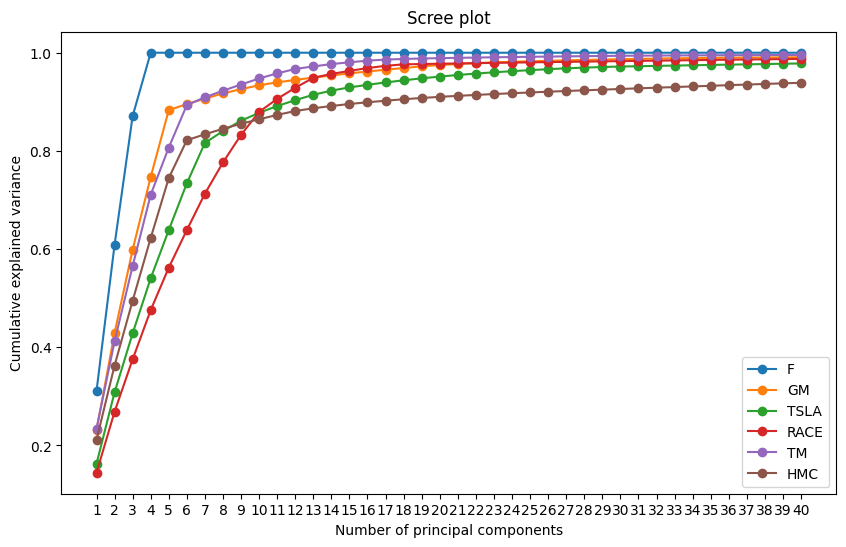

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

plt.figure(figsize=(10, 6))

# Define el mapa de colores
color_map = plt.get_cmap('tab10')

# Itera a través de cada marca
for i, brand in enumerate(brands):
    # Extrae el DataFrame correspondiente a la marca actual
    dfs = lagged_stationary_dataframes[brand].copy()

    # Separa las características y la variable objetivo
    df_features = dfs.drop(['Target', 'Nominal_Close'], axis=1)

    # Define el modelo PCA
    pca = PCA()

    # Escala las características
    scaler = RobustScaler()
    df_features_scaled = pd.DataFrame(scaler.fit_transform(df_features), columns=df_features.columns)

    # Ajusta el modelo PCA
    pca.fit(df_features_scaled)

    # Calcula la varianza acumulada
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

    # Dibuja la línea de la varianza acumulada para la marca actual
    plt.plot(range(1, len(cumulative_variance[:40]) + 1), cumulative_variance[:40], '-o', label=brand, color=color_map(i))

    # Imprime las 5 variables más importantes para cada una de las 5 primeras componentes
    print(f'Brand: {brand}')
    for j in range(5):
        # Recupera los coeficientes de la componente principal
        component = pca.components_[j]

        # Asocia cada coeficiente con el nombre de la característica correspondiente
        feature_weights = dict(zip(df_features.columns, component))

        # Ordena las características por el valor absoluto de su peso y toma las 5 primeras
        top_features = sorted(feature_weights.items(), key=lambda x: abs(x[1]), reverse=True)[:5]

        print(f'Component {j+1}: {cumulative_variance[j]}')
        for feature, weight in top_features:
            print(f'  {feature}: {weight}')

    print('\n')

# Añade etiquetas y título
plt.title('Scree plot')
plt.xlabel('Number of principal components')
plt.ylabel('Cumulative explained variance')
plt.legend()
plt.xticks(range(1, 41))

plt.show()



# FUNCIONES AUXILIARES

La función `errors` calcula y muestra el MAE, MAPE, MDAPE y RMSE entre `y_test` y `y_pred`. Luego, imprime los valores redondeados a 4 decimales. Para utilizarla, llama a la función `errors` pasando `y_test` y `y_pred` como argumentos.

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def errors(y_test, y_pred):

    # Mean Absolute Error (MAE)
    MAE = mean_absolute_error(y_test, y_pred)

    # Mean Absolute Percentage Error (MAPE)
    MAPE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    # Median Absolute Percentage Error (MDAPE)
    MDAPE = np.median(np.abs((y_test - y_pred) / y_test)) * 100

    RMSE = math.sqrt(mean_squared_error(y_test,y_pred))
        # Mean Absolute Error (MAE)
    print(f'Mean Absolute Error (MAE): {np.round(MAE, 4)}')

    # Mean Absolute Percentage Error (MAPE)
    print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 4)} %')

    # Median Absolute Percentage Error (MDAPE)
    print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 4)} %')

    # Mean Quatratic Error(RMSE)
    print(f'Mean Quatratic Error (RMSE): {np.round(RMSE, 4)}')

    return MAE, MAPE, MDAPE, RMSE


Función para transformar de incremento porcentual a valor nominal
La función `transform_targets` ajusta las columnas de destino en el DataFrame `df`. Se calcula la longitud de los datos de entrenamiento y la fecha límite de entrenamiento. Luego, se realizan las transformaciones necesarias en las columnas de destino basadas en las condiciones especificadas. Finalmente, se devuelve el DataFrame modificado. Para usar esta función, pasa el DataFrame, el porcentaje de datos de entrenamiento y, opcionalmente, el nombre de la columna de cierre.

In [ ]:
def transform_targets(df, train_perc, close_col='Nominal_Close'):
    # Obteniendo las fechas correspondientes a las posiciones de train_data_len - 1 y train_data_len
    train_data_len = math.ceil(df.shape[0] * train_perc)
    train_date_limit = df.index[train_data_len]
    for col in df.columns:
        if col == 'residuals':
            df.loc[train_date_limit:, col] = df.loc[train_date_limit:, col] * df.loc[train_date_limit:, close_col]
        elif col == 'y_train':
           df.loc[:train_date_limit, col] = df.loc[:train_date_limit, col] * df.loc[:train_date_limit, close_col] + df.loc[:train_date_limit, close_col]
        elif col != close_col:
            df.loc[train_date_limit:, col] = df.loc[train_date_limit:, col] * df.loc[train_date_limit:, close_col] + df.loc[train_date_limit:, close_col]
    return df


In [ ]:
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

Función utilizada para el input de la LSTM

La función `partition_dataset` divide un conjunto de datos en secuencias de longitud `sequence_length`. Se crea una lista `x` para almacenar las secuencias y una lista `y` para almacenar las etiquetas correspondientes. Se itera sobre los datos desde `sequence_length` hasta la longitud total de los datos, agregando las secuencias a `x` y las etiquetas a `y`. Finalmente, se convierten `x` e `y` en arrays numpy y se devuelven. Para usar esta función, pasa la longitud de la secuencia, los datos y la variable objetivo.

In [ ]:
def partition_dataset(sequence_length, data, target):
    x, y = [], []
    data_len = data.shape[0]

    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i]) # contains sequence_length values 0-sequence_length from feature columns
        y.append(target[i]) # contains the prediction values for validation, for single-step prediction

    x = np.array(x)
    y = np.array(y)
    return x, y


Selección de variables y escalado

La función `feature_scaling_and_selection` realiza el escalado y la selección de características según los parámetros proporcionados. Se separan las características y la variable objetivo del DataFrame y se aplican escaladores a las características y las predicciones. Si se especifica, se realiza la selección de características utilizando Lasso o PCA. Finalmente, se devuelve un array numpy de características escaladas, un array numpy de variable objetivo escalada y el escalador utilizado para las predicciones. Para utilizar esta función, pasa el DataFrame y, opcionalmente, establece los parámetros para la selección y transformación de características.





In [ ]:
from sklearn.model_selection import GridSearchCV

def feature_scaling_and_selection(df, stockname=None, stationary=False, lagged = False, use_Lasso=False, use_PCA=False):
    # Separate the target variable from the features
    dfs = df.copy()
    if stationary:
        df_features = dfs.drop(['Target', 'Nominal_Close'], axis=1)
        df_target = dfs['Target']
        df_Nominal_Close = dfs['Nominal_Close']
    else:
        df_features = dfs.drop('Target', axis=1)
        df_target = dfs['Target']


    # Scaling the features
    scaler = RobustScaler()
    df_features_scaled = pd.DataFrame(scaler.fit_transform(df_features), columns=df_features.columns)

    # Creating a separate scaler that works on a single column for scaling predictions
    scaler_pred = RobustScaler()
    df_target_scaled = pd.Series(scaler_pred.fit_transform(df_target.values.reshape(-1, 1)).flatten())



        # Apply Lasso transformation if Lasso is set to True
    if use_Lasso:
        # Selecciona las características importantes
        if lagged:
          df_features_scaled = df_features_scaled[lassofeatures_lags[stockname]]
        else:
          df_features_scaled = df_features_scaled[lassofeatures_nolags[stockname]]

    # Apply PCA transformation if PCA is set to True
    if use_PCA:
        pca = PCA(n_components=0.93)
        np_data_scaled = pca.fit_transform(df_features_scaled)
        scaler = RobustScaler()
        np_data_scaled = scaler.fit_transform(np_data_scaled)
    else:
        # Converting the dataframe to arrays
        nrows = df_features.shape[0]
        np_data_scaled = np.reshape(np.array(df_features_scaled), (nrows, -1))
    np_target_scaled = df_target_scaled.values.reshape(-1,1)


    return np_data_scaled, np_target_scaled, scaler_pred


Pruebas varias


In [ ]:
def train_test_transform(df, train_perc = 0.8):
  dfs = df.copy()

  df_features = dfs.drop(['Target', 'Nominal_Close'], axis=1)
  df_target = dfs['Target']


  train_data_len = math.ceil(dfs.shape[0] * train_perc)
  X_train, X_test, y_train, y_test = df_features[:train_data_len], df_features[train_data_len:], df_target[:train_data_len], df_target[train_data_len:]


  scaler_X = RobustScaler()
  # Ajusta el escalador a los datos de entrenamiento y transforma los conjuntos de datos
  X_train_scaled = scaler_X.fit_transform(X_train)
  X_test_scaled = scaler_X.transform(X_test)
  return X_train_scaled, X_test_scaled, y_train, y_test




Nuestra función train_test_split


La función `train_test_split` divide los datos y la variable objetivo en conjuntos de entrenamiento y prueba. Se calcula la longitud de los datos de entrenamiento en base al porcentaje especificado. Luego, se crean los conjuntos de entrenamiento y prueba según la longitud calculada. Si se especifica para LSTM, los conjuntos se generan en secuencias utilizando la función `partition_dataset`. Finalmente, se devuelven los conjuntos de entrenamiento y prueba. Para utilizar esta función, pasa los datos, la variable objetivo y el porcentaje de entrenamiento, y opcionalmente establece los parámetros para LSTM y la longitud de la secuencia.

In [ ]:
def train_test_split(np_data, np_target_scaled, train_perc, for_LSTM = False, sequence_length = 0):

    # Split the training data into train and train data sets
    # As a first step, we get the number of rows to train the model on 80% of the data
    train_data_len = math.ceil(np_data.shape[0] * train_perc)

    # Create the training and test data
    train_data = np_data[:train_data_len]
    train_target = np_target_scaled[:train_data_len]

    if for_LSTM == True:
        test_data = np_data[train_data_len - sequence_length:, :]
        test_target = np_target_scaled[train_data_len - sequence_length:, :]

        # Generate training data and test data
        X_train, y_train = partition_dataset(sequence_length, train_data, train_target)
        X_test, y_test = partition_dataset(sequence_length, test_data, test_target)
        # Validate that the prediction value and the input match up
        # The last close price of the second input sample should equal the first prediction value
        print(X_train[1][sequence_length-1][0])
        print(y_train[0])

    else :
        X_train, X_test, y_train, y_test = train_data, np_data[train_data_len:], train_target, np_target_scaled[train_data_len:]


    # Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
    print(X_train.shape, y_train.shape)
    print(X_test.shape, y_test.shape)


    return X_train, X_test, y_train, y_test

Añadir los resultados a un dataframe


La función `results_df` crea un DataFrame de resultados que combina los datos de entrenamiento, las etiquetas reales, las etiquetas predichas y los residuos. Se calcula la longitud de los datos de entrenamiento en base al porcentaje especificado. Luego, se crean los DataFrames de entrenamiento y prueba a partir de las columnas correspondientes del DataFrame original. Se agregan las columnas de etiquetas predichas y residuos al DataFrame de prueba. Finalmente, se devuelve el DataFrame combinado.





In [ ]:
def results_df(df, stockname, train_perc, stationary, y_pred):

    train_data_len = math.ceil(df.shape[0] * train_perc)
    train = pd.DataFrame(df['Target'][:train_data_len]).rename(columns={'Target': 'y_train'})
    valid = pd.DataFrame(df['Target'][train_data_len:]).rename(columns={'Target': 'y_test'})
    valid.insert(1, "y_pred", y_pred, True)
    valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
    df_union = pd.concat([train, valid])
    if stationary:
            df_union['Nominal_Close'] = df['Nominal_Close']
            df_union = transform_targets(df_union, train_perc)
    return df_union

Modelo de la red LSTM

La función `model_LSTM` crea un modelo LSTM utilizando Keras. Se añaden capas LSTM con el número de neuronas especificado, se aplica Dropout para regularización, y se añaden capas densas. El modelo se compila con el optimizador, la función de pérdida y se devuelve. Para utilizar esta función, pasa los datos de entrenamiento y opcionalmente establece los parámetros del modelo.





In [ ]:
def model_LSTM(x_train, neurons=50, optimizer='adam', loss='mean_squared_error', learn_rate="standard", dropout_rate=0.1, dense_rate=32, activation='relu'):
    model = Sequential()
    model.add(LSTM(neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(neurons, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(neurons, return_sequences=False))
    model.add(Dense(dense_rate))
    model.add(Dense(1, activation))
    model.compile(optimizer=optimizer, loss=loss)
    return model


Función final de la LSTM

La función `final_LSTM` entrena un modelo LSTM utilizando los datos de entrada. Se muestra la pérdida del entrenamiento y la validación en un gráfico. Se realizan predicciones utilizando el modelo entrenado y se invierte el escalado para obtener los valores predichos y las etiquetas reales en su escala original. Se calculan las métricas de error y se muestran en la consola. Finalmente, se crea un DataFrame con los resultados y se muestra un gráfico con las predicciones y los errores.

In [ ]:

def final_LSTM(df, stockname, display_start_date = "2019-01-01" , stationary = False, train_perc = 0.8, sequence_length=50,
                neurons = 50, epochs=50, batch_size=32, patience=8,  optimizer='adam', loss='mean_squared_error',
               learn_rate = "standard", activation='relu', use_PCA=False, use_Lasso=False, dense_rate = 32, dropout_rate = 0.1, lagged = False):

    np_data, np_target_scaled, scaler_pred = feature_scaling_and_selection(df, stockname, stationary, lagged, use_Lasso, use_PCA)
    x_train, x_test, y_train, y_test = train_test_split(np_data, np_target_scaled, train_perc,  for_LSTM = True, sequence_length = sequence_length)

    # Configure the neural network model
    model = model_LSTM(x_train, neurons, optimizer, loss, learn_rate, dropout_rate, dense_rate, activation)



    early_stop = EarlyStopping(monitor='loss', patience=patience, verbose=1)
    history = model.fit(x_train, y_train,  batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), callbacks=[early_stop], shuffle = True)

    # history = model.fit(x_train, y_train, validation_split=0.33,  batch_size=batch_size, epochs=epochs)


    # Plot training & validation loss values
    fig, ax = plt.subplots(figsize=(12, 6), sharex=True)
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("Model loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Test"], loc="upper left")
    plt.show()

    # Get the predicted values
    y_pred_scaled = model.predict(x_test)

    # Unscale the predicted values
    y_pred = scaler_pred.inverse_transform(y_pred_scaled)
    y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

    df_union = results_df(df, stockname, train_perc, stationary, y_pred)


    MAE, MAPE, MDAPE, RMSE = errors(df_union['y_test'].dropna(), df_union['y_pred'].dropna())


    # Zoom in to a closer timeframe
    df_union_zoom = df_union[df_union.index > display_start_date]

    # Create the lineplot
    fig, ax1 = plt.subplots(figsize=(16, 8))
    plt.title("y_pred vs y_test")
    plt.ylabel(stockname, fontsize=18)
    sns.set_palette(["#090364", "#1960EF", "#EF5919"])
    sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

    # Create the barplot for the absolute errors
    df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
    ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='absolute errors', color=df_sub)
    plt.legend()
    plt.show()

    return df_union


In [ ]:
for brand in brands:
  r1 = final_LSTM(stationary_dataframes[brand], brand, display_start_date = "2019-01-01" , stationary = True, train_perc = 0.8, sequence_length=50,
               neurons = 50, epochs=50, batch_size=32, patience=8,  optimizer='adam', loss='mean_squared_error', learn_rate = "standard", activation='relu', use_PCA=False, use_Lasso=False, dense_rate = 32, dropout_rate = 0.1)


In [ ]:
r1 = final_LSTM(stationary_dataframes['GM'], 'GM', display_start_date = "2019-01-01" , stationary = True, train_perc = 0.8, sequence_length=100,
               neurons = 50, epochs=100, batch_size=45, patience=8,  optimizer='adam', loss='mean_squared_error', learn_rate = "standard", activation='relu', use_PCA=False, use_Lasso=False, dense_rate = 32, dropout_rate = 0.3)


In [ ]:
r1 = final_LSTM(stationary_dataframes['GM'][['Close', 'Nominal_Close', 'LBOLLINGER', 'Target']], 'GM', display_start_date = "2019-01-01" , stationary = True, train_perc = 0.8, sequence_length=50,
               neurons = 50, epochs=3, batch_size=32, patience=8,  optimizer='adam', loss='mean_squared_error', learn_rate = "standard", activation='relu', use_PCA=False, use_Lasso=False, dense_rate = 32, dropout_rate = 0.3)


In [ ]:
r1 = final_LSTM(stationary_dataframes['F'], 'F', display_start_date = "2019-01-01" , stationary = True, train_perc = 0.8, sequence_length=50,
               neurons = 50, epochs=50, batch_size=32, patience=3,  optimizer='adam', loss='mean_squared_error', learn_rate = "standard", activation='relu', use_PCA=False, use_Lasso=False, dense_rate = 32, dropout_rate = 0.1)


In [ ]:
r1 = final_LSTM(stationary_dataframes['F'], 'F', display_start_date = "2019-01-01" , stationary = True, train_perc = 0.8, sequence_length=50,
               neurons = 50, epochs=50, batch_size=32, patience=8,  optimizer='adam', loss='mean_squared_error', learn_rate = "standard", activation='relu', use_PCA=False, use_Lasso=False, dense_rate = 32, dropout_rate = 0.1)


OTHER ML MODELS

In [ ]:
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, HistGradientBoostingRegressor
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV,TimeSeriesSplit



La función `plot_predictions` muestra un gráfico de las predicciones y los valores reales. Se seleccionan los datos del DataFrame a partir de la fecha de inicio especificada. Luego, se crea un gráfico con líneas para las predicciones, los valores de entrenamiento y los valores reales. Finalmente, se muestra el gráfico.





In [ ]:

def plot_predictions(df_union, stockname, display_start_date="2023-01-01"):
    df_union_zoom = df_union[df_union.index > display_start_date]
    fig, ax1 = plt.subplots(figsize=(16, 8))
    plt.title("y_pred vs y_test")
    plt.ylabel(stockname, fontsize=18)
    sns.set_palette(["#090364", "#1960EF", "#EF5919"])
    sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

Optmización de parámetros para XGboost

El código realiza una búsqueda de hiperparámetros utilizando XGBoost y la clase `RandomizedSearchCV`. Se itera sobre las marcas en la lista `brands`, se realiza el escalado y la selección de características, y se dividen los datos en conjuntos de entrenamiento y prueba. Luego, se realiza la búsqueda de hiperparámetros utilizando `RandomizedSearchCV` y se imprime el mejor conjunto de hiperparámetros encontrado para cada marca.





In [ ]:
import xgboost as xgb
grid_xgb = {
    'n_estimators': [50, 100, 500, 1000],
    'max_depth': np.arange(2, 7, 1),
    'learning_rate': [0.01, 0.05, 0.1, 0.5, 1],
    'booster': ['gbtree', 'gblinear', 'dart'],
    'objective': ['reg:linear']
}
for brand in brands:
  print('----------------------------------------------', brand, '-------------------------------------------------------------')
  np_data_scaled, np_target_scaled, scaler_pred = feature_scaling_and_selection(lagged_stationary_dataframes[brand], brand, stationary = True, use_Lasso = True, use_PCA = False, lagged = True)
  X_train, X_test, y_train, y_test = train_test_split(np_data_scaled, np_target_scaled, 0.8)
  rscv = RandomizedSearchCV(estimator=xgb.XGBRegressor(), param_distributions=grid_xgb, cv=2, n_jobs=-1, verbose=2, n_iter=25)
  rscv_fit = rscv.fit(X_train, y_train)
  best_parameters = rscv_fit.best_params_
  print(best_parameters)

---------------------------------------------- F -------------------------------------------------------------
(4114, 393) (4114, 1)
(1028, 393) (1028, 1)
Fitting 2 folds for each of 25 candidates, totalling 50 fits
[14:13:05] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
{'objective': 'reg:linear', 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'booster': 'dart'}
---------------------------------------------- GM -------------------------------------------------------------
(1500, 102) (1500, 1)
(374, 102) (374, 1)
Fitting 2 folds for each of 25 candidates, totalling 50 fits
[14:19:58] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
{'objective': 'reg:linear', 'n_estimators': 50, 'max_depth': 2, 'learning_rate': 0.05, 'booster': 'gbtree'}
---------------------------------------------- TSLA -------------------------------------------------------------
(1

Optimización de parámetros para RF

El código realiza una búsqueda de hiperparámetros utilizando `RandomizedSearchCV` para un modelo de Random Forest. Se define una cuadrícula de hiperparámetros, se crea una instancia de `RandomizedSearchCV` con el estimador y la cuadrícula, se realiza la búsqueda utilizando los conjuntos de entrenamiento y se imprime el mejor conjunto de hiperparámetros encontrado.





In [ ]:
grid_rf = {
'n_estimators': [20, 50, 100, 500, 1000],
'max_depth': np.arange(1, 15, 1),
'min_samples_split': [2, 10, 9],
'min_samples_leaf': np.arange(1, 15, 2, dtype=int),
'bootstrap': [True, False],
'random_state': [1, 2, 30, 42]
}
rscv = RandomizedSearchCV(estimator=model, param_distributions=grid_rf, cv=3, n_jobs=-1, verbose=2, n_iter=200)
rscv_fit = rscv.fit(x_train, y_train)
best_parameters = rscv_fit.best_params_
print(best_parameters)

In [ ]:
np_data_scaled, np_target_scaled, scaler_pred = feature_scaling_and_selection(stationary_dataframes['F'], 'F', stationary = True, use_Lasso = False, use_PCA= False, lagged= False)
np_data_scaled.size

606912

Función para utilizar XGboost

La función `xgboost_model` entrena un modelo XGBoost utilizando los datos de entrada y muestra la pérdida de entrenamiento y validación en un gráfico. Luego, se realizan predicciones utilizando el modelo entrenado, se invierte el escalado para obtener los valores predichos y las etiquetas reales en su escala original. A continuación, se calculan las métricas de error, como el MAE, MAPE, MDAPE y RMSE, y se muestra un gráfico con las predicciones y los errores.






In [ ]:
import xgboost as xgb
def xgboost_model(df, brand, booster = 'gbtree',base_score=0.5, objective='reg:linear',  early_stopping_rounds=50, n_estimators = 1000, max_depth = 3, learning_rate = 0.01,  stationary = True, use_Lasso = False, use_PCA = False, train_perc = 0.8, display_start_date = "2022-01-01", lagged = True ):
  np_data_scaled, np_target_scaled, scaler_pred = feature_scaling_and_selection(df, brand, stationary, use_Lasso, use_PCA, lagged)

  X_train, X_test, y_train, y_test = train_test_split(np_data_scaled, np_target_scaled, train_perc)

  reg = xgb.XGBRegressor(base_score = base_score, booster = booster,
                        n_estimators = n_estimators,
                        early_stopping_rounds = early_stopping_rounds,
                        objective = objective,
                        max_depth = max_depth,
                        learning_rate = learning_rate)
  reg.fit(X_train, y_train,
          eval_set=[(X_test, y_test)],eval_metric='rmse',
          verbose=False)
    # Obtiene las métricas de evaluación
  results = reg.evals_result()

  # Obtiene la pérdida de entrenamiento
  train_loss = results['validation_0']['rmse']

  # Obtiene la pérdida de validación
  val_loss = results['validation_0']['rmse']

  # Crea una lista de épocas
  epochs = range(1, len(train_loss) + 1)

  # Crea el gráfico
  plt.plot(epochs, train_loss, label='Training loss')
  plt.plot(epochs, val_loss, label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
  y_pred = reg.predict(X_test)
  # Convert the arrays back to the original scale
  y_test = scaler_pred.inverse_transform(y_test)
  y_pred= scaler_pred.inverse_transform(y_pred.reshape(-1,1))

  df_union = results_df(df, brand, train_perc, stationary, y_pred)
  print('Sin pct_change')


  MAE, MAPE, MDAPE, RMSE = errors(df_union['y_test'].dropna(), df_union['y_pred'].dropna())

  df_union_zoom = df_union[df_union.index > display_start_date]
  # Plot the actual values
  fig, ax1 = plt.subplots(figsize=(16, 8))
  plt.title("y_pred vs y_test")
  plt.ylabel(brand, fontsize=18)
  sns.set_palette(["#090364", "#1960EF", "#EF5919"])
  sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

  plt.xlabel('Time')
  plt.ylabel(brand)
  plt.legend()
  df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
  ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='absolute errors', color=df_sub)
  plt.legend()

  plt.show()

In [ ]:
xgboost_model(stationary_dataframes['F'], brand, stationary = True, use_Lasso = False, use_PCA = False, train_perc = 0.8 )

In [ ]:
for brand in brands:
  print('-----------------------------------------------------', brand, '----------------------------------------------------------------------------------------')
  xgboost_model(lagged_stationary_dataframes[brand], brand, stationary = True, use_Lasso = False, use_PCA = False, train_perc = 0.8 )

In [ ]:
for brand in brands:
  print('-----------------------------------------------------', brand, '----------------------------------------------------------------------------------------')
  xgboost_model(lagged_stationary_dataframes[brand], brand, stationary = True, use_Lasso = True, use_PCA = False, train_perc = 0.8 )

In [ ]:
for brand in brands:
  print('-----------------------------------------------------', brand, '----------------------------------------------------------------------------------------')
  xgboost_model(lagged_stationary_dataframes[brand], brand, stationary = True, use_Lasso = False, use_PCA = True, train_perc = 0.8 )

# Optimización XGboost

In [ ]:
xgboost_model(lagged_stationary_dataframes['F'], 'F', booster = 'dart', n_estimators = 500, max_depth = 4, learning_rate = 0.05,  stationary = True, use_Lasso = False, use_PCA = True, train_perc = 0.8, display_start_date = "2022-01-01", lagged = True )

In [ ]:
xgboost_model(lagged_stationary_dataframes['GM'], 'GM', booster = 'gbtree', n_estimators = 1000, max_depth = 2, learning_rate = 0.01,  stationary = True, use_Lasso = False, use_PCA = True, train_perc = 0.8, display_start_date = "2022-01-01", lagged = True )

In [ ]:
xgboost_model(lagged_stationary_dataframes['TSLA'], 'TSLA', booster = 'dart', n_estimators = 1000, max_depth = 2, learning_rate = 0.15,  stationary = True, use_Lasso = False, use_PCA = True, train_perc = 0.8, display_start_date = "2022-01-01", lagged = True )

In [ ]:
xgboost_model(lagged_stationary_dataframes['RACE'], 'RACE', booster = 'gbtree', n_estimators = 100, max_depth = 1, learning_rate = 0.05,  stationary = True, use_Lasso = False, use_PCA = True, train_perc = 0.8, display_start_date = "2022-01-01", lagged = True )

In [ ]:
xgboost_model(lagged_stationary_dataframes['TM'], 'TM', booster = 'gbtree', n_estimators = 1000, max_depth = 1, learning_rate = 0.05,  stationary = True, use_Lasso = False, use_PCA = True, train_perc = 0.8, display_start_date = "2022-01-01", lagged = True )

In [ ]:
xgboost_model(lagged_stationary_dataframes['HMC'], 'HMC', booster = 'dart', n_estimators = 1000, max_depth = 1, learning_rate = 0.01,  stationary = True, use_Lasso = False, use_PCA = True, train_perc = 0.8, display_start_date = "2022-01-01", lagged = True )

# RANDOM FOREST

La función `random_forest_model` entrena un modelo de Random Forest utilizando los datos de entrada y muestra las predicciones en un gráfico. Luego, se invierte el escalado para obtener los valores predichos y las etiquetas reales en su escala original. Se calculan las métricas de error, como el MAE, MAPE, MDAPE y RMSE, y se muestra un gráfico con las predicciones y los errores.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

def random_forest_model(df, brand, stationary = True, use_Lasso = False, use_PCA = False, train_perc = 0.8, display_start_date = "2022-01-01", lagged = True ):
    np_data_scaled, np_target_scaled, scaler_pred = feature_scaling_and_selection(df, brand, stationary, use_Lasso, use_PCA, lagged)

    X_train, X_test, y_train, y_test = train_test_split(np_data_scaled, np_target_scaled, train_perc)

    reg = RandomForestRegressor(n_estimators=1000)
    reg.fit(X_train, y_train)

    y_pred = reg.predict(X_test)
    # Convert the arrays back to the original scale
    y_test = scaler_pred.inverse_transform(y_test)
    y_pred= scaler_pred.inverse_transform(y_pred.reshape(-1,1))

    df_union = results_df(df, brand, train_perc, stationary, y_pred)
    print('Sin pct_change')

    MAE, MAPE, MDAPE, RMSE = errors(df_union['y_test'].dropna(), df_union['y_pred'].dropna())

    df_union_zoom = df_union[df_union.index > display_start_date]
    # Plot the actual values
    fig, ax1 = plt.subplots(figsize=(16, 8))
    plt.title("y_pred vs y_test")
    plt.ylabel(brand, fontsize=18)
    sns.set_palette(["#090364", "#1960EF", "#EF5919"])
    sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

    plt.xlabel('Time')
    plt.ylabel(brand)
    plt.legend()
    df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
    ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='absolute errors', color=df_sub)
    plt.legend()

    plt.show()


In [ ]:
for brand in brands:
  random_forest_model(lagged_stationary_dataframes[brand], brand, stationary = True, use_Lasso = False, use_PCA = False, train_perc = 0.8, display_start_date = "2022-01-01", lagged = True )

In [ ]:
for brand in brands:
  random_forest_model(lagged_stationary_dataframes[brand], brand, stationary = True, use_Lasso = True, use_PCA = False, train_perc = 0.8, display_start_date = "2022-01-01", lagged = True )

In [ ]:
for brand in brands:
  random_forest_model(lagged_stationary_dataframes[brand], brand, stationary = True, use_Lasso = False, use_PCA = True, train_perc = 0.8, display_start_date = "2022-01-01", lagged = True )

El código proporcionado traza un gráfico de comparación entre las predicciones (`y_pred2`) y los valores reales (`y2`) de las primeras 100 muestras. Las predicciones se muestran como puntos rojos y los valores reales como puntos azules. Se traza una línea verde entre cada predicción y su valor real correspondiente. El gráfico muestra la comparación visual entre las predicciones y los valores reales.

In [ ]:
y2 = y_test[:100]
y_pred2 = y_pred[:100]

x = range(len(y2))
fig, ax = plt.subplots(figsize=(10, 5))
ci = 1.96*RMSE
for i,v in enumerate(y_pred2):
    plt.plot([x[i],x[i]], [v,y2[i]],color="green")
#ax.fill_between(x, ( y_pred2-ci), ( y_pred2+ci), color='b', alpha=.1)
ax.scatter(x,y_pred2,color="red",s=8,label="predicho")
ax.scatter(x,y2,color="blue",s=8,label="real")
plt.legend()
plt.show()

# Hyperparameter Tunning LSTM

In [ ]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV,TimeSeriesSplit
from google.colab import files

In [ ]:
stationary_dataframes['F']

,Open,Close,High,Low,Volume,MA1,MA2,Cash & Equivalents,Short-Term Investments,Cash & Cash Equivalents,...,EMA50,MACD,ADX,CMF,SO,LBOLLINGER,HBOLLINGER,FI,Target,Nominal_Close
Date,,,,,,,,,,,,,,,,,,,,,
1999-07-01,0.074766,0.037562,0.023033,0.058449,-0.164224,-0.001857,0.000992,0.22622,-0.042296,0.009737,...,0.001021,-0.376589,-0.042467,-0.367238,98.833333,-0.005897,0.008758,0.512772,-0.086407,58.56
1999-07-02,0.018435,-0.019126,-0.001194,0.015575,-0.451210,-0.002236,0.000955,0.22622,-0.042296,0.009737,...,0.000211,-0.351215,-0.041183,0.319225,80.166667,-0.001876,0.003646,-0.268510,-0.078343,57.44
1999-07-06,-0.018101,0.004352,-0.001025,0.001046,-0.183130,-0.002087,0.001096,0.22622,-0.042296,0.009737,...,0.000374,-0.481443,-0.039884,0.104229,84.175084,-0.001435,0.002476,-0.111536,-0.072630,57.69
1999-07-07,0.001043,-0.003293,-0.004274,-0.006616,-0.083668,-0.002280,0.001112,0.22622,-0.042296,0.009737,...,0.000229,-0.671500,-0.049418,-0.140005,80.976431,-0.001767,0.004158,-0.167408,-0.059826,57.50
1999-07-08,-0.002085,-0.017391,-0.013906,-0.016299,0.313135,-0.002611,0.000935,0.22622,-0.042296,0.009737,...,-0.000466,-0.534716,-0.068508,-0.047979,64.141414,-0.000020,0.002161,-0.346650,-0.045310,56.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-16,-0.012821,-0.033505,-0.011945,-0.030198,0.137564,-0.002818,-0.001300,0.00000,0.000000,0.000000,...,-0.002692,0.334020,0.059450,1.821720,0.952381,0.000969,-0.012806,1.498242,0.011556,11.25
2023-05-17,-0.017316,0.022222,0.005181,0.007117,-0.172477,-0.002244,-0.001455,0.00000,0.000000,0.000000,...,-0.001780,0.053313,0.037106,-0.482207,24.761905,-0.001270,-0.004695,-0.491319,0.051304,11.50
2023-05-18,0.009692,0.012174,0.001718,0.011484,-0.237553,-0.002249,-0.001380,0.00000,0.000000,0.000000,...,-0.001257,-0.041633,0.028216,0.430013,38.095238,-0.001168,-0.000798,-0.435345,0.081615,11.64


En el código proporcionado se realiza una búsqueda de hiperparámetros utilizando la función `RandomizedSearchCV` para el modelo LSTM en cada marca de `brands`. Se especifican los posibles valores para los hiperparámetros `optimizer`, `dropout_rate`, `neurons` y `activation`. Se entrena el modelo utilizando los datos de entrenamiento y se realiza una búsqueda aleatoria de los mejores parámetros. Se imprimen los mejores parámetros encontrados y se guardan los resultados en un archivo Excel.

In [ ]:

optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adam', 'Adamax', 'Nadam']
dropout_rate = [0.0, 0.1, 0.3, 0.6, 0.9]
neurons = [20, 25, 30, 40, 50, 60]
activation = ['sigmoid', 'tanh', 'relu', 'leaky_relu']

for brand in brands:
  np_data, np_target_scaled, scaler_pred = feature_scaling_and_selection(stationary_dataframes[brand], brand, stationary = True)
  X_train, x_test, Y_train, y_test = train_test_split(np_data, np_target_scaled, for_LSTM = True,train_perc = 0.8, sequence_length=50)

  param_grid2 = dict(optimizer=optimizer, dropout_rate=dropout_rate, neurons=neurons, x_train = [X_train], activation = activation)

  # envoltura de scikit-learn para el modelo keras
  model_stationary = KerasRegressor(build_fn=model_LSTM, verbose=0)




  # búsqueda de random

  grid_stat = RandomizedSearchCV(estimator=model_stationary, param_distributions=param_grid2, n_iter = 500, n_jobs=-1, cv=3)
  grid_stat.fit(X_train, Y_train)
  print("Mejor: %f usando %s" % (grid_stat.best_score_, grid_stat.best_params_))
  resultados = pd.DataFrame(grid_stat.cv_results_)
  resultados = resultados.sort_values('rank_test_score')
  resultados.to_excel(f'{brand}-Resultados_Parameters_hypertunning.xlsx', encoding = 'utf-8-sig')
  files.download(f'{brand}-Resultados_Parameters_hypertunning.xlsx')


0.3497709558583013
[-1.15455771]
(4451, 50, 98) (4451, 1)
(1125, 50, 98) (1125, 1)


<ipython-input-40-03310965c75c>:13: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_stationary = KerasRegressor(build_fn=model_LSTM, verbose=0)
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Mejor: -0.756191 usando {'x_train': array([[[-9.54370751e-01, -1.36176038e+00, -1.11693650e+00, ...,
         -5.98531361e-01, -8.07339573e-01, -1.34261072e+00],
        [-1.29075980e+00, -6.80208363e-01, -8.43619159e-01, ...,
         -1.11627684e+00, -1.79583195e-01, -7.54181458e+01],
        [-1.64493170e-01,  3.12503709e-01,  6.57112419e-01, ...,
         -5.14600711e-01, -9.88364734e-01, -5.11297061e-01],
        ...,
        [-3.46503595e-01, -1.78781192e+00, -7.83795673e-01, ...,
         -2.50668175e+00, -2.77379825e-01,  8.28235315e-01],
        [ 4.11619060e-01,  2.23761627e+00,  1.26873717e+00, ...,
         -9.27349608e-01, -3.15422464e-01, -1.16324288e+00],
        [-6.92360427e-01, -1.21432902e+00, -4.98174484e-01, ...,
         -1.59100553e+00, -2.05255793e-02,  1.89084731e+00]],

       [[-1.29075980e+00, -6.80208363e-01, -8.43619159e-01, ...,
         -1.11627684e+00, -1.79583195e-01, -7.54181458e+01],
        [-1.64493170e-01,  3.12503709e-01,  6.57112419e-01, ...,
  

/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py:211: FutureWarning: the 'encoding' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'encoding'
  return func(*args, **kwargs)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
brands[]

['F', 'GM', 'TSLA', 'RACE', 'TM', 'HMC']

In [ ]:
resultados = pd.DataFrame(grid_stat.cv_results_)
resultados = resultados.sort_values('rank_test_score')
resultados.to_excel('Resultados_Parameters_hypertunning.xlsx', encoding = 'utf-8-sig')
files.download('Resultados_Parameters_hypertunning.xlsx')

In [ ]:
print("Mejor: %f usando %s" % (grid_stat.best_score_, grid_stat.best_params_))
#print("Mejor: %f usando %s" % (grid_stat.best_score_, grid_stat.best_params_))

# REG. LINEAL

En el código proporcionado se define una función `linear_regression_model` que entrena un modelo de regresión lineal utilizando los datos de entrada y realiza predicciones. Se invierte el escalado para obtener los valores predichos y las etiquetas reales en su escala original. Se calcula el coeficiente de determinación (R2) como medida de evaluación del modelo. Se generan gráficos para visualizar las predicciones y los errores.

Luego, se realiza un bucle sobre las marcas en la lista `brands` y se llama a la función `linear_regression_model` pasando los datos correspondientes a cada marca.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error

def linear_regression_model(df, brand, stationary = True, lagged = True, use_Lasso = False, use_PCA = False, train_perc = 0.8, display_start_date = "2022-01-01" ):
    np_data_scaled, np_target_scaled, scaler_pred = feature_scaling_and_selection(df, brand, stationary, use_Lasso, use_PCA, lagged)

    X_train, X_test, y_train, y_test = train_test_split(np_data_scaled, np_target_scaled, train_perc)

    linear_reg = LinearRegression()
    modelo = linear_reg.fit(X_train, y_train.ravel())

    y_pred = modelo.predict(X_test)
    # Convert the arrays back to the original scale
    y_test = scaler_pred.inverse_transform(y_test)
    y_pred = scaler_pred.inverse_transform(y_pred.reshape(-1,1))
    print('Con pct_change')
    r2 = r2_score(y_test,y_pred)
    print('r2:', r2)
    df_union = results_df(df, brand, train_perc, stationary, y_pred)
    print('Sin pct_change')
    r2 = r2_score(df_union['y_test'].dropna(), df_union['y_pred'].dropna())
    print('r2:', r2)

    MAE, MAPE, MDAPE, RMSE = errors(df_union['y_test'].dropna(), df_union['y_pred'].dropna())

    df_union_zoom = df_union[df_union.index > display_start_date]
    # Plot the actual values
    fig, ax1 = plt.subplots(figsize=(16, 8))
    plt.title("y_pred vs y_test")
    plt.ylabel(brand, fontsize=18)
    sns.set_palette(["#090364", "#1960EF", "#EF5919"])
    sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

    plt.xlabel('Time')
    plt.ylabel(brand)
    plt.legend()
    df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
    ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='absolute errors', color=df_sub)
    plt.legend()

    plt.show()

for brand in brands:
  print('-----------------------------------------------------', brand, '----------------------------------------------------------------------------------------')
  linear_regression_model(lagged_stationary_dataframes[brand], brand, stationary = True, use_Lasso = False, use_PCA = False, train_perc = 0.8 )

In [ ]:
for brand in brands:
  print('-----------------------------------------------------', brand, '----------------------------------------------------------------------------------------')
  linear_regression_model(lagged_stationary_dataframes[brand], brand, stationary = True, use_Lasso = True, use_PCA = False, train_perc = 0.8 )

In [ ]:
for brand in brands:
  print('-----------------------------------------------------', brand, '----------------------------------------------------------------------------------------')
  linear_regression_model(lagged_stationary_dataframes[brand], brand, stationary = True, use_Lasso = False, use_PCA = True, train_perc = 0.8 )